# OpenEO endpoint in Examind - Example - Web Editor

By Quentin BIALOTA (Geomatys)

Contact : quentin.bialota@geomatys.com

---

### **/!\ WARNING**
This initial implementation of openEO may contain bugs. Please let me know if you find any.

In this tutorial we will the web editor to create and execute openEO processes on Examind.

---

**Prerequisites :**
- Have an examind (via docker) running on your machine
- Have imported sentinel-2 data in Examind (through the web ui http://localhost/8080/examind [login: admin / password: admin])
- In examind, have created a WCS (in Web Services page) named `test` (with the sentinel-2 data you imported)
- In examind, have created a WPS (in Web Services page) named `test` (you need to enable Versions `1.0.0` **AND** `2.0.0`)
- In the examind docker, have added the Web Editor service (you can access it on http://localhost:8096)
  ```yml
    openeo-web-editor:
      image: mundialis/openeo-web-editor:latest
      container_name: openo-web-editor
      ports:
        - "8096:80"
      restart: unless-stopped
  ```
- Also in the docker compose, have added the following environment variables to the examind service :
  ```yml
    environment:
      EXAMIND_ENABLE_BASIC_AUTH: "true" # To be able to authenticate on openEO endpoints
      EXAMIND_ENABLE_PARAM_TOKEN: "true" # To be able to authenticate on openEO endpoints
      EXAMIND_WPS_EXECUTE_SECURE: "true" # To enable the safety check when executing WPS processes via openEO
  ```

### 1 - Connect to examind openEO endpoint
![server connection](./images/web-editor-server-connection.png)

Put here the url of the openEO endpoint of your examind instance :
*Ex : http://localhost:8080/examind/WS/openeo/test*

The format is : `<SERVER_IP>/examind/WS/openeo/<OPENEO_SERVICE_ID>`

Then, click on **Connect**.

---

You have to login with your examind credentials (admin/admin for example).

![authentication](./images/web-editor-authentication.png)

Then, click on **Log in**.

You also can use web editor with **No credentials** mode, but in this case you won't be able to create or execute processes.

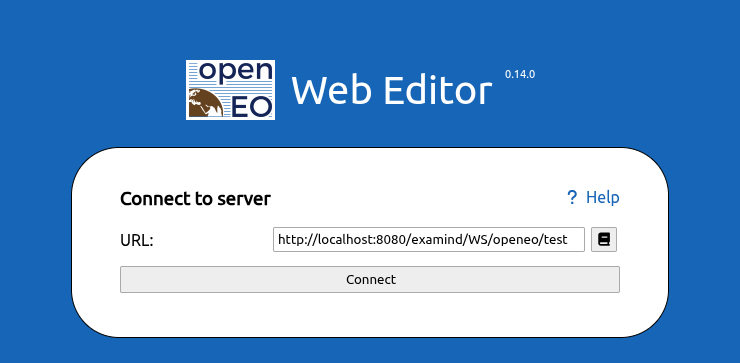
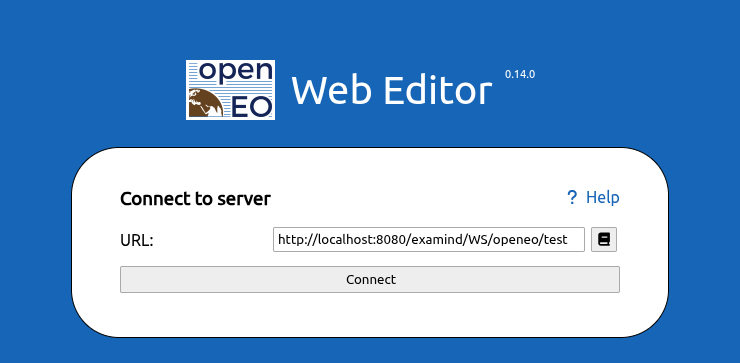

### 2- Web editor interface overview

In the web editor, you have several tabs on the left side of the interface.
- **Collections** : to see the data collections available on the server
- **Processes** : to see the processes available on the server
- **Export File Formats** : to see the export file formats available on the server

On the right side, you have the **process graph editor**, where you can create your own process graphs.
You can create your process using the **visual model** (little boxes) or the **json editor** (json code).


![interface](./images/web-editor-interface.png)

### 3 - Collections information and main processes available

In the **Collections** tab, you can see the data collections available on the server.
In this example, we have only one collection : `sentinel_evi_bands` (the sentinel-2 data we imported before).

If you click on the collection, you can see its information :
- ID
- License
- Description
- Spatial extent
- Temporal extent
- Data Cube Dimensions (list of dimensions availables + bands)
- Bands information (legend of bands available)
- CRS information
- links

![collection-information](./images/web-editor-collection-information.png)

If you **drag and drop** the collection on the process graph editor, it will create a `load_collection` process for you.

![load-collection-process](./images/web-editor-sentinel_evi_bands_process.png)

You can edit this process to change its parameters (spatial extent, temporal extent, bands...).

- Select **Bouding Box** to set the spatial extent
- Select **No filter** for the temporal extent (because our data has no time dimension)
- Select **Bands identifier to select** and put `[1,2,3]` to load bands 1, 2 and 3

![load-collection-process](./images/web-editor-sentinel_evi_bands_process_edit.png)

Then, you can create a **save_result** process to save the result of your process graph.

You can find it in the "Processes" tab (you can use the search bar to find it faster).
Drag and drop it on the process graph editor.

Link the output of the `load_collection` process to the input of the `save_result` process.

And set the format to `GTIFF`.

![save-result-process](./images/web-editor-save_result.png)

You have your first process graph ready to be executed !
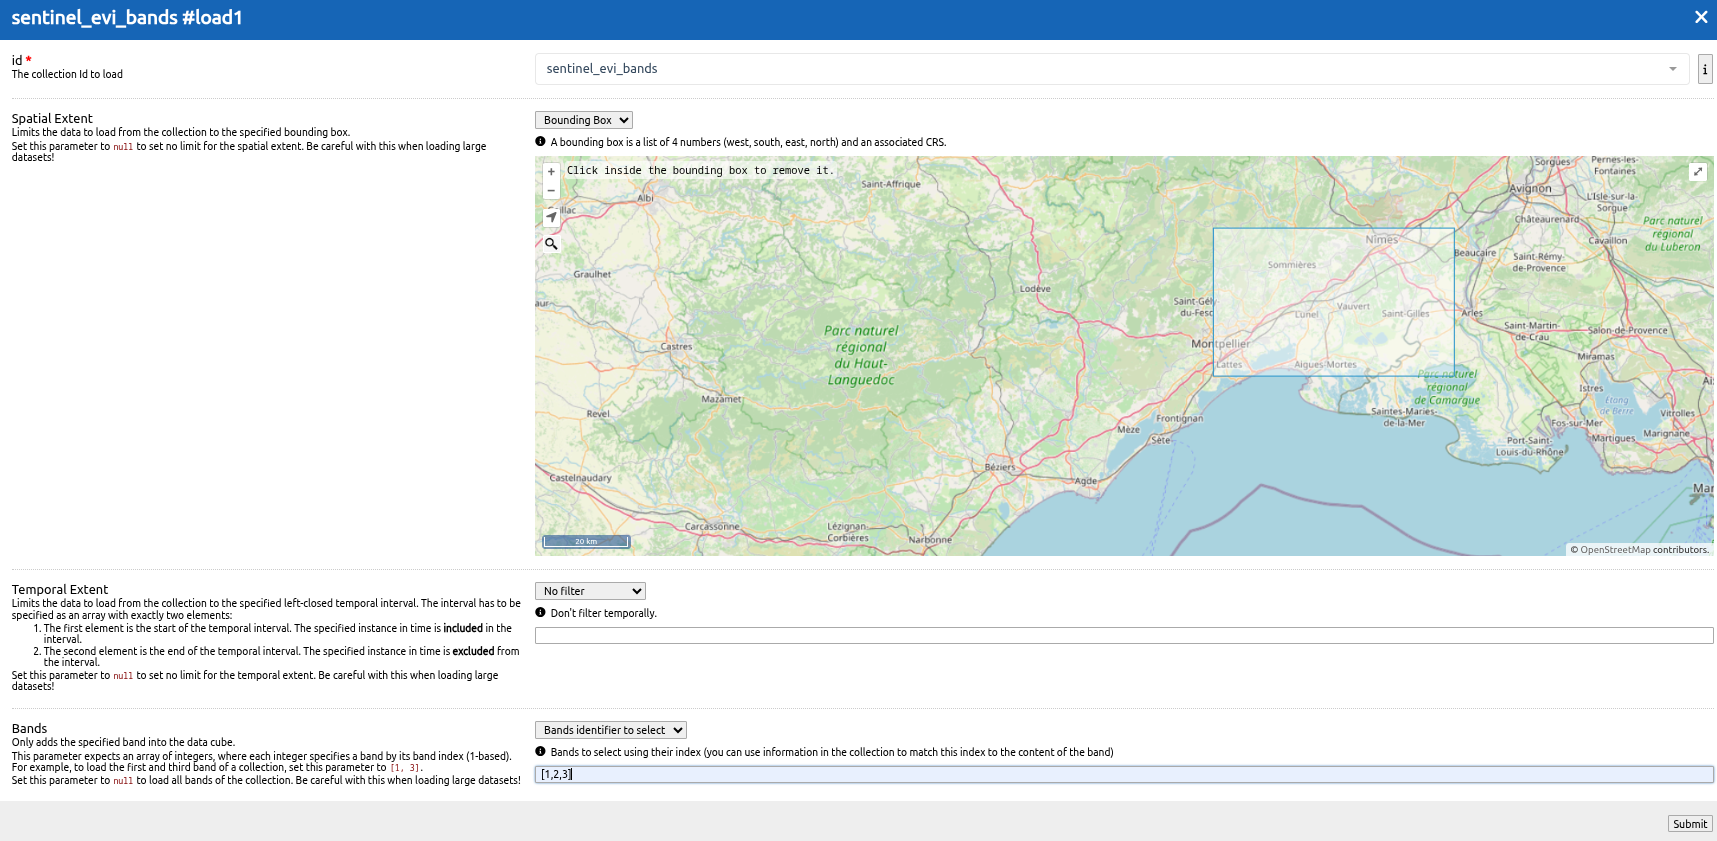

### 4 - A full example with an EVI process

We are going to create an EVI (Enhanced Vegetation Index) process by ourselves, directly via json in the web editor.

- You can find the EVI formula here : https://en.wikipedia.org/wiki/Enhanced_vegetation_index

- In this tutorial, we will give the process in json, but you also can recreate it using the visual model of the web editor.

**Copy paste this json in the web editor json editor tab to create the EVI process**

It will create something like this in the visual model tab :

![evi-process-graph](./images/web-editor-evi-graph.png)

In [ ]:
{
    "id": "test-execution",
    "summary": "Enhanced Vegetation Index",
    "description": "Computes the Enhanced Vegetation Index (EVI). It is computed with the following formula: `2.5 * (NIR - RED) / (1 + NIR + 6*RED + -7.5*BLUE)`.",
    "parameters": [],
    "returns": {
        "description": "Computed EVI.",
        "schema": {
            "type": "object"
        }
    },
    "process_graph": {
        "1": {
            "process_id": "geotoolkit.coverage:math:substract",
            "arguments": {
                "first": {
                    "from_node": "geotoolkit3"
                },
                "second": {
                    "from_node": "geotoolkit1"
                }
            }
        },
        "2": {
            "process_id": "geotoolkit.coverage:math:multiplyWithValue",
            "arguments": {
                "coverage": {
                    "from_node": "geotoolkit1"
                },
                "value": 6.0
            }
        },
        "3": {
            "process_id": "geotoolkit.coverage:math:multiplyWithValue",
            "arguments": {
                "coverage": {
                    "from_node": "geotoolkit2"
                },
                "value": 7.5
            }
        },
        "load1": {
            "process_id": "load_collection",
            "arguments": {
                "id": "sentinel_evi_bands",
                "spatial_extent": {
                    "west": 3.87,
                    "east": 4.5,
                    "north": 43.85,
                    "south": 43.56,
                    "crs": "urn:ogc:def:crs:OGC:1.3:CRS84"
                },
                "bands": [
                    0,
                    2,
                    4
                ]
            }
        },
        "geotoolkit1": {
            "process_id": "geotoolkit.coverage:bandselect",
            "arguments": {
                "coverage": {
                    "from_node": "load1"
                },
                "bands": [
                    0
                ]
            }
        },
        "geotoolkit2": {
            "process_id": "geotoolkit.coverage:bandselect",
            "arguments": {
                "coverage": {
                    "from_node": "load1"
                },
                "bands": [
                    1
                ]
            }
        },
        "geotoolkit3": {
            "process_id": "geotoolkit.coverage:bandselect",
            "arguments": {
                "coverage": {
                    "from_node": "load1"
                },
                "bands": [
                    2
                ]
            }
        },
        "geotoolkit4": {
            "process_id": "geotoolkit.coverage:math:sum",
            "arguments": {
                "first": {
                    "from_node": "geotoolkit3"
                },
                "second": {
                    "from_node": "2"
                }
            }
        },
        "geotoolkit5": {
            "process_id": "geotoolkit.coverage:math:sum",
            "arguments": {
                "first": {
                    "from_node": "geotoolkit4"
                },
                "second": {
                    "from_node": "3"
                }
            }
        },
        "geotoolkit7": {
            "process_id": "geotoolkit.coverage:math:sumWithValue",
            "arguments": {
                "coverage": {
                    "from_node": "geotoolkit5"
                },
                "value": 1.0
            }
        },
        "geotoolkit8": {
            "process_id": "geotoolkit.coverage:math:divide",
            "arguments": {
                "second": {
                    "from_node": "geotoolkit7"
                },
                "first": {
                    "from_node": "1"
                }
            }
        },
        "geotoolkit9": {
            "process_id": "geotoolkit.coverage:math:multiplyWithValue",
            "arguments": {
                "coverage": {
                    "from_node": "geotoolkit8"
                },
                "value": 2.5
            }
        },
        "save10": {
            "process_id": "save_result",
            "arguments": {
                "coverage": {
                    "from_node": "geotoolkit9"
                },
                "format": "GTIFF"
            },
            "result": true
        }
    },
    "parameters": []
}

You can run this process in a **synchronous** way (for small data) or in an **asynchronous** way (for big data).

#### Synchronous execution

Clicl on **Run now**.

![synchronous-execution](./images/web-editor-synchronous.png)

After a few seconds, you should see the result appear in the **Results** tab.
You also can download the result.

**/!\ WARNING : The result tab is not working, the date displayed is not correct.**

#### Asynchronous execution

Click on **Create Batch Job**.

A popup appears to configure the batch job.
Click directly on **Submit**.

Refresh the Data processing tab, you will see the job.

![batch job](./images/web-editor-batch-job.png)

To run this job, click on the play button on the right side of the job.

![batch job running](./images/web-editor-batch-job-running.png)

After a few seconds, the job status should be **Finished**.

![batch job finished](./images/web-editor-batch-job-finished.png)

You can see the result in the **Results** tab.

**/!\ WARNING : The result tab is not working, the date displayed is not correct.**

Or you can download the result by clicking on the download button on the right side of the job.

![batch job result](./images/web-editor-async-download.png)

---

Result in QGIS :
![synchronous-result-qgis](./images/result-qgis.png)
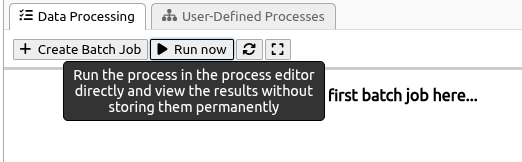
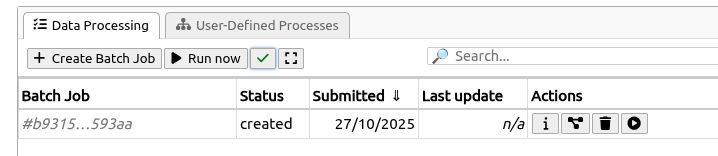
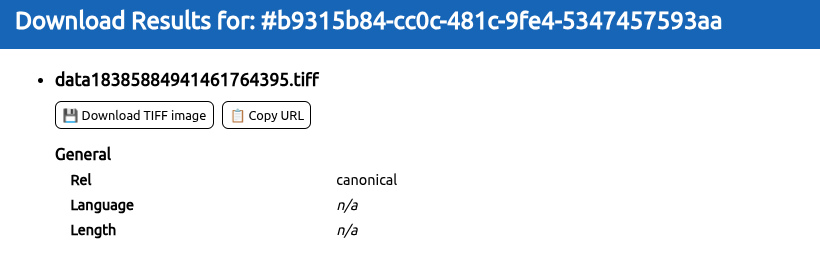